# Numerical simulation of FAST applied to a coarse imaging of flakes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipyparallel as ipp

In [3]:
cluster = ipp.Cluster(engines="mpi", n=12)

In [4]:
rc = cluster.start_and_connect_sync()

Starting 12 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/12 [00:00<?, ?engine/s]

In [5]:
dv = rc[:]

In [6]:
rc

In [7]:
%%px

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [8]:
%%px --local
from pathlib import Path

import blosc2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile as tif
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import load_image_list_renormalize
from image_labels import labels
from tqdm.notebook import tqdm

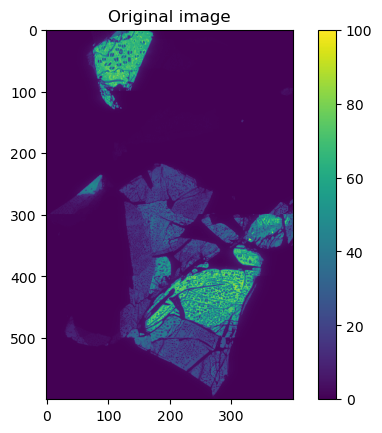

In [9]:
# Taking a generic image, then cropping and rescaling it
flakes = load_image_list_renormalize(
    [Path.home() / "code/fast_smart_scanning/work_directory/sims_paper/fused_full.tif"], img_format="tif"
)[0]

plt.figure()
plt.imshow(flakes)
plt.title("Original image")
plt.colorbar()
plt.show()

In [10]:
dv["flakes"] = flakes

### Simulating the FAST procedure only

In [11]:
# Get a 1% measurement mask
init_pattern = gcn(*flakes.T.shape, 0.01)

Initial ratio is 0.01


Text(0.5, 1.0, 'Initial scan pattern')

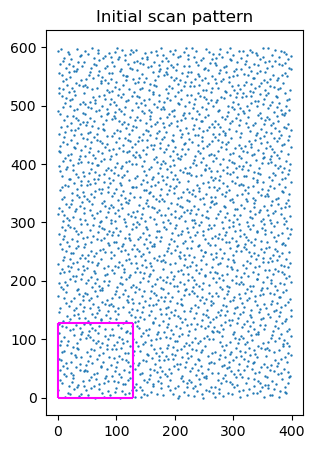

In [12]:
plt.figure(figsize=[5, 5])
plt.scatter(init_pattern[:, 1], init_pattern[:, 0], s=0.5)
plt.vlines([0, 128], ymin=0, ymax=128, color="magenta")
plt.hlines([0, 128], xmin=0, xmax=128, color="magenta")
plt.gca().set_aspect("equal")
plt.title("Initial scan pattern")

In [13]:
dv["init_pattern"] = init_pattern

In [14]:
models_list = list(Path.cwd().glob("trained_models/*/c_2/*_relu.pkl"))
# models_list = list(Path.cwd().glob('trained_models/5.1.11/c_2/*_relu.pkl'))

In [15]:
names = [m.parent.parent.name for m in models_list]
models_to_compare = {n: m for n, m in zip(names, models_list)}
models_to_compare[
    "cameraman"
] = "/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl"

In [16]:
list(models_to_compare.items())

[('4.1.05',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.05/c_2/erd_model_relu.pkl')),
 ('4.1.01',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.01/c_2/erd_model_relu.pkl')),
 ('camera_new',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/camera_new/c_2/erd_model_relu.pkl')),
 ('4.2.03',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.03/c_2/erd_model_relu.pkl')),
 ('5.1.11',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.11/c_2/erd_model_relu.pkl')),
 ('4.1.08',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.08/c_2/erd_model_relu.pkl')),
 ('5.3.01',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/wor

In [17]:
len(models_to_compare.items())

12

In [18]:
dv.scatter("models", models_to_compare)

<AsyncResult(scatter): pending>

In [19]:
dv["models_to_compare"] = models_to_compare

In [20]:
%%px
masks_all = []
recons_fast_all = []
ratios_all = []
tot_erds_all = []
samples_all = []

for mtype in models:
    model = models_to_compare[mtype]
    print(model)
    sample_this = utils.create_experiment_sample(
        numx=flakes.shape[1],
        numy=flakes.shape[0],
        inner_batch_size=50,
        initial_idxs=init_pattern,
        erd_model_file_path=model,
    )
    masks_this = []
    recons_fast_this = []
    ratios_this = []
    tot_erds_this = []

    count = 0
    new_idxs = init_pattern

    n_scan_points = int(0.4 * flakes.size)
    pbar = tqdm(total=n_scan_points, desc="Scanned points")

    count = 0
    # Continue until we measure 40% of the points.
    while sample_this.mask.sum() < n_scan_points:
        # Supply the measurement values.
        sample_this.measurement_interface.finalize_external_measurement(flakes[new_idxs[:, 0], new_idxs[:, 1]])

        # Supply in measurement positions
        sample_this.perform_measurements(new_idxs)

        # Use the measurement values to reconstruct the sample and calculate the ERDs
        sample_this.reconstruct_and_compute_erd()

        # Compute new positions.
        new_idxs = sample_this.find_new_measurement_idxs()[:50]

        ratio = sample_this.ratio_measured

        ratios_this.append(ratio)
        tot_erds_this.append(sample_this.ERD.sum())
        recons_fast_this.append(sample_this.recon_image.copy())
        masks_this.append(sample_this.mask.copy())

        pbar.update(int(sample_this.mask.sum() - pbar.n))

    masks_all.append(masks_this)
    recons_fast_all.append(recons_fast_this)
    ratios_all.append(ratios_this)
    tot_erds_all.append(tot_erds_this)
    samples_all.append(sample_this)

[stdout:1] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.01/c_2/erd_model_relu.pkl


[stderr:1] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stdout:2] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/camera_new/c_2/erd_model_relu.pkl


[stderr:2] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stdout:4] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.11/c_2/erd_model_relu.pkl


[output:1]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stdout:10] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/all_combined/c_2/erd_model_relu.pkl


[stderr:4] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stdout:7] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.06/c_2/erd_model_relu.pkl


[stdout:9] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.12/c_2/erd_model_relu.pkl


[stdout:6] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.3.01/c_2/erd_model_relu.pkl


[stdout:5] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.08/c_2/erd_model_relu.pkl


[stderr:10] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:2]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stderr:7] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:6] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:9] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:5] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:4]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[output:10]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[output:6]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[output:9]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[output:7]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stdout:11] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl


[output:5]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stderr:11] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:11]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stdout:0] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.05/c_2/erd_model_relu.pkl


[stdout:3] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.03/c_2/erd_model_relu.pkl


[stderr:3] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:0] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stdout:8] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.07/c_2/erd_model_relu.pkl


[output:3]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[output:0]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

[stderr:8] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:8]

Scanned points:   0%|          | 0/96000 [00:00<?, ?it/s]

%px:   0%|          | 0/12 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [21]:
%%px
labels_this = []
for m in models:
    if m in labels:
        labels_this.append(labels[m])
    else:
        labels_this.append(m)

Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [22]:
%%px

checkpoint_frequency = 10

data_to_save = [
    np.ascontiguousarray(d[0])[::checkpoint_frequency] for d in [ratios_all, recons_fast_all, masks_all, tot_erds_all]
]

Received Keyboard Interrupt. Sending signal SIGINT to engines...


In [23]:
%%px
joblib.dump(data_to_save, f"fast_sim_data/coarse_flakes/{labels_this[0]}_data.joblib", compress=5)

Received Keyboard Interrupt. Sending signal SIGINT to engines...


Stopping controller
Failed to remove /home/beams0/SKANDEL/.ipython/profile_default/log/ipcontroller-1678480042-3krj-610040.log: [Errno 2] No such file or directory: '/home/beams0/SKANDEL/.ipython/profile_default/log/ipcontroller-1678480042-3krj-610040.log'
Controller stopped: {'exit_code': 0, 'pid': 610059, 'identifier': 'ipcontroller-1678480042-3krj-610040'}
Stopping engine(s): 1678480043


Stopping cluster <Cluster(cluster_id='1678480042-3krj', profile='default', controller=<running>, engine_sets=['1678480043'])>


engine set stopped 1678480043: {'exit_code': 1, 'pid': 610151, 'identifier': 'ipengine-1678480042-3krj-1678480043-610040'}


In [57]:
rc.shutdown(hub=True)

Controller stopped: {'exit_code': 0, 'pid': 602427, 'identifier': 'ipcontroller-1678470413-57ph-602409'}
engine set stopped 1678470415: {'exit_code': 0, 'pid': 602503, 'identifier': 'ipengine-1678470413-57ph-1678470415-602409'}
Stopping engine(s): 1678470415
